# SEPAR Tutorial: A Quick Start Guide  

This tutorial demonstrates the core functionalities of SEPAR (Spatial gene Expression PAttern Recognition) using the DLPFC (Dorsolateral Prefrontal Cortex) dataset. SEPAR is designed to identify spatial patterns in spatial transcriptomics data through graph-regularized matrix factorization.  

## Key Features  
- Spatial pattern identification  
- Pattern-specific gene detection   
- Spatially variable gene (SVG) identification  
- Gene expression refinement
- Spatial domain clustering

## Data Availability  

The DLPFC dataset used in this tutorial can be accessed through multiple sources:  

- **Dataset**: The processed DLPFC data is hosted in the [spatialLIBD repository](https://github.com/LieberInstitute/spatialLIBD)  
- **Manual Annotations**: Expert-curated layer annotations are available in [supplementary data folder](https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing)  

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from SEPAR_model import SEPAR

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Loading and Preparing Data

We'll work with the DLPFC dataset. Here's how to load and prepare the data:

In [2]:
# Define parameters for the specific slice
slice_idx = 151507
algorithm_params = {
    "151507": {"nslt": 3000, "alpha": 0.7, "l1": 0.01, "lam": 0.3}
}
params = algorithm_params.get(str(slice_idx), {})

# Load annotation data
anno_df = pd.read_csv('dataset/DLPFC/barcode_level_layer_map.tsv', sep='\t', header=None)

# Read Visium data
adata = sc.read_visium(path="dataset/DLPFC//%d" % slice_idx,
                      count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx)
adata.var_names_make_unique()

# Process annotations
anno_df1 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx)]
anno_df1.columns = ["barcode", "slice_id", "layer"]
anno_df1.index = anno_df1['barcode']
adata.obs = adata.obs.join(anno_df1, how="left")
adata = adata[adata.obs['layer'].notna()]

# Initialize SEPAR
n_cluster = len(adata.obs['layer'].unique())
separ = SEPAR(adata.copy(), n_cluster=n_cluster)
separ.adata.obs['Region'] = separ.adata.obs['layer']

## Data Preprocessing

SEPAR includes several preprocessing steps:

After filtering:  (4221, 12597)


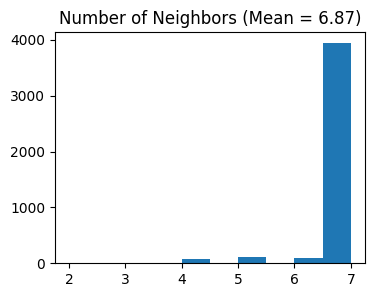

Counting moran's i ...

Finish selecting


In [3]:
# Preprocess the data
separ.preprocess(min_cells=40, n_top_genes=6000)

# Compute spatial graph
separ.compute_graph()

# Select features using Moran's I
separ.select_morani(nslt=params['nslt'])

# Compute weights
separ.compute_weight(n_cluster=n_cluster)

#### Parameters Explanation:

- `min_cells`: Minimum number of cells required for a gene to be considered
- `n_top_genes`: Number of highly variable genes to select
- `nslt`: Number of spatially variable genes to select using Moran's I statistic
- `n_cluster`: Number of expected spatial domains/clusters

## 1. Running SEPAR Algorithm

In [4]:
# Run SEPAR algorithm
separ.separ_algorithm(
    r=30,              # Number of spatial patterns
    alpha=0.7,         # Graph regularization weight
    beta=0.01,         # Sparsity penalty weight (previously l1)
    gamma=0.3          # Pattern orthogonality weight (previously lam)
)

Processing iterations: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


#### Parameters Explanation:
- `r`: Integer
  - Number of spatial patterns to identify

- `alpha`: Float
  - Weight for graph regularization term
  - Controls spatial smoothness of patterns
  - Typical range: 0.1-1.0

- `beta`: Float (previously l1)
  - Weight for sparsity penalty
  - Controls pattern distinctness and localization
  - Typical range: 0.01-0.1

- `gamma`: Float (previously lam)
  - Weight for pattern orthogonality term
  - Controls redundancy between patterns
  - Typical range: 0.1-1.0

#### Results:
- `separ.Wpn`: Spatial patterns matrix (W in the paper)
- `separ.Hpn`: Gene loading matrix (H in the paper)
- `separ.err_list`: Reconstruction errors during optimization

## 2. Identifying Pattern-Specific Genes

In [5]:
# Identify pattern-specific genes  
pattern_genes = separ.identify_pattern_specific_genes(  
    n_patterns=30,    # Number of patterns to consider  
    threshold=0.3     # Threshold for gene-pattern association  
)  

#### Parameters Explanation:  
- `n_patterns`: Integer (default=30)  
  - Number of top patterns to analyze  
  - Should be less than or equal to total patterns from decomposition  
- `threshold`: Float (default=0.3)  
  - Threshold for determining pattern-specific genes  
  - Higher values yield more stringent gene selection  

#### Results Storage:  
- `self.pattern_specific_mask`: List of boolean arrays  
  - Length equals to `n_patterns`  
  - Each array indicates which genes are specific to that pattern  
- `self.genes_per_pattern`: Number of specific genes per pattern  
- `self.Wpnn`, `self.Hpnn`: Normalized pattern and gene loading matrices 

#### Return:  
- `pattern_genes`: List of lists  
  - Length equals to `n_patterns`  
  - Each sublist contains genes specific to that pattern  
  - Genes are sorted by specificity score   

### Pattern Visualization and Pattern-specific Genes

First, let's visualize the identified spatial patterns and analyze their characteristics:

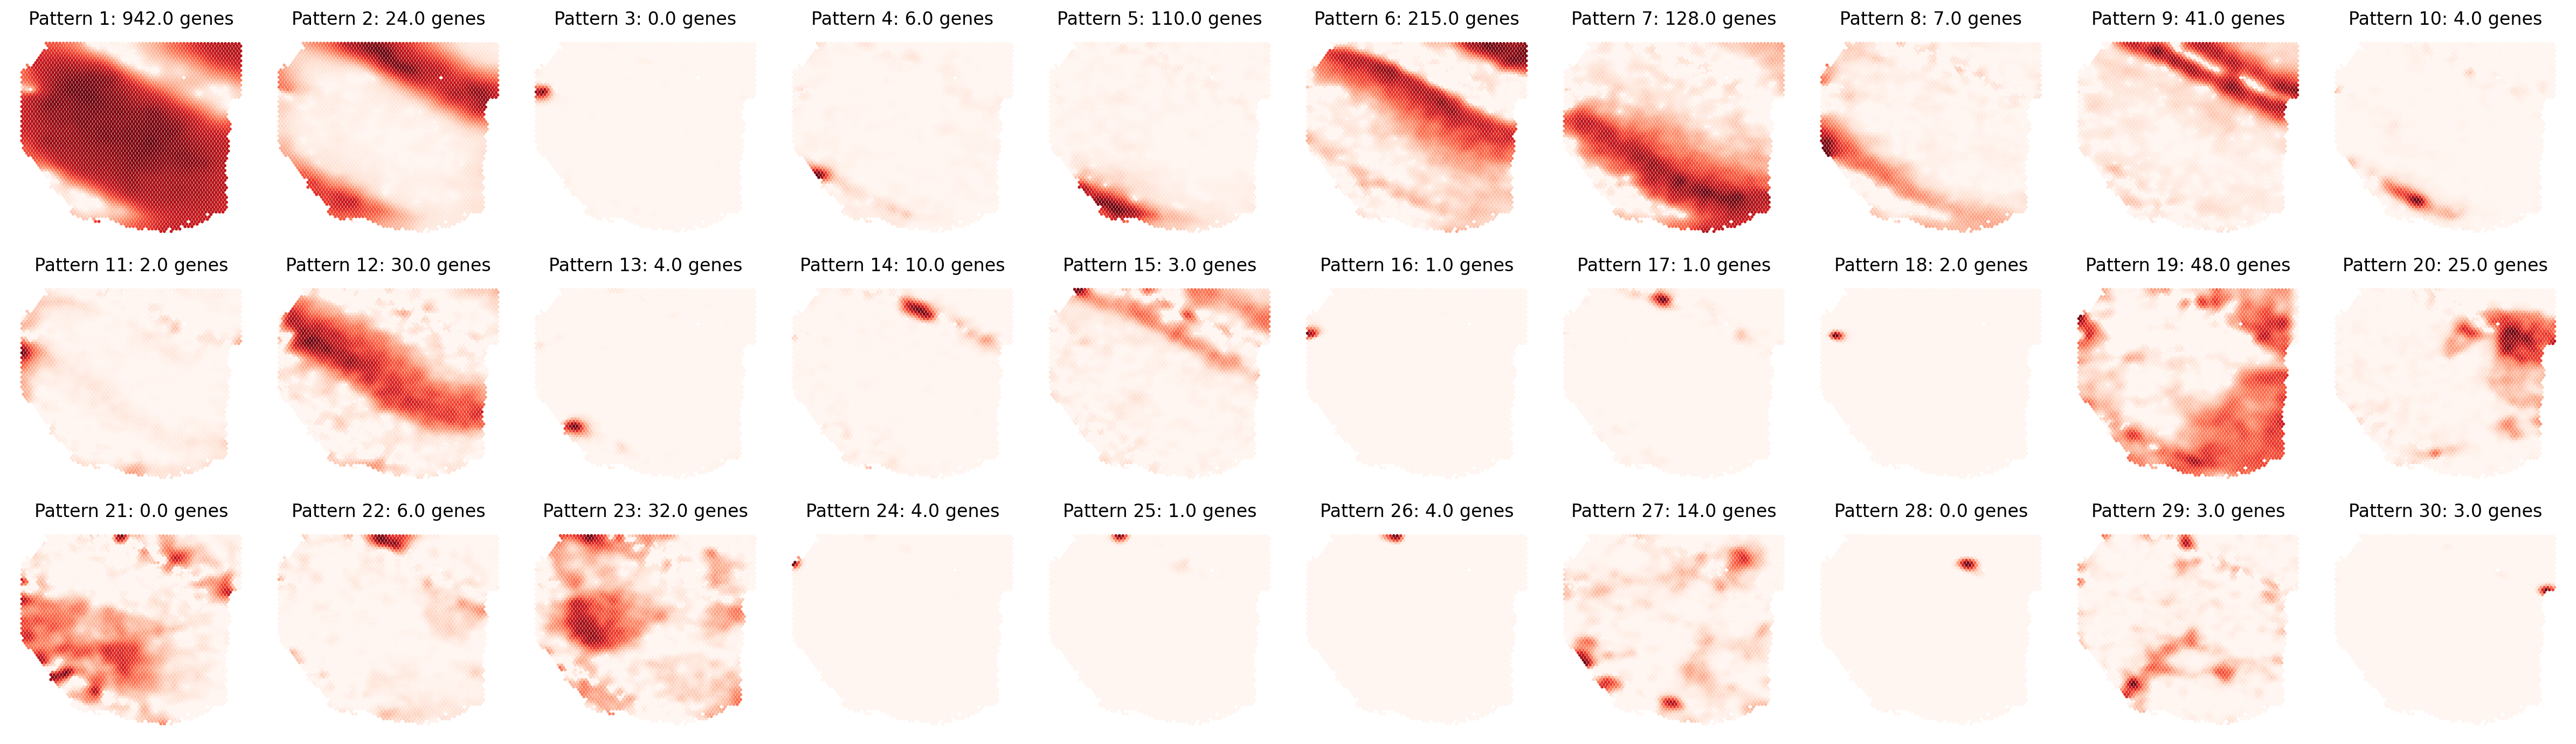

In [6]:
# Visualize all spatial patterns
sim_slt = separ.sim_res(separ.Wpn, separ.Hpn, separ.Xt.T)
sim_argsort = np.argsort(-sim_slt)

num_patterns = 30
plt.figure(dpi=200, figsize=(24, 7))
for i in range(30):
    ii = sim_argsort[i]
    plt.subplot(3, np.int(num_patterns/3), i + 1)
    plt.scatter(separ.loc[:, 0], -separ.loc[:, 1], 
                c=separ.Wpn[:, ii].reshape(-1, 1), 
                s=1.2, cmap='Reds')
    plt.axis('off')
    plt.title(f'Pattern {i + 1}: {separ.genes_per_pattern[ii]} genes', 
              fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
# Create and display sorted pattern-specific genes table  
print("\nTop Pattern-Specific Genes (Sorted by Pattern Significance):")  
print("-" * 100)  
print(f"{'Pattern':11} | {'Significance':11} | {'#Genes':8} | {'Top Genes'}")  
print("-" * 100)  

for rank, pattern_idx in enumerate(sim_argsort[:30]):  
    genes = pattern_genes[pattern_idx]  
    if len(genes) == 0:  
        gene_str = "None"  
    else:  
        gene_str = ", ".join(genes[:10])  
        if len(genes) > 10:  
            gene_str += "..."  
    
    print(f"Pattern {rank+1:<3} | {sim_slt[pattern_idx]:.4f}      | {len(genes):<8} | {gene_str}")  
print("-" * 100)  


Top Pattern-Specific Genes (Sorted by Pattern Significance):
----------------------------------------------------------------------------------------------------
Pattern     | Significance | #Genes   | Top Genes
----------------------------------------------------------------------------------------------------
Pattern 1   | 0.9418      | 942      | ATP1A3, HINT1, UCHL1, CISD1, VGF, CHCHD10, TUBB2A, NDUFA4, COX4I1, SNAP25...
Pattern 2   | 0.8872      | 24       | GFAP, GALNT15, CST3, APLNR, MT-ND2, MT-ND1, MT3, MT-ATP6, MT-ND4, MT-CYB...
Pattern 3   | 0.7692      | 0        | None
Pattern 4   | 0.7480      | 6        | LTB, CCL19, TACSTD2, PIGB, RLBP1, IRF7
Pattern 5   | 0.7298      | 110      | LDB3, GJB1, ERMN, GLDN, NKX6-2, PLEKHH1, ANLN, AQP1, CARNS1, FAM222A...
Pattern 6   | 0.6737      | 215      | LINC00507, NEUROD1, NEK2, CALB1, EFCAB1, FFAR4, LRRTM4, SHISA8, PENK, KCNA4...
Pattern 7   | 0.6705      | 128      | TRABD2A, LRMP, FEZF2, TSHZ2, PCP4, GAL, SMYD2, MKX, HS3ST2, CLSTN

## 3. Spatially Variable Genes (SVGs) Analysis

In [8]:
# Get SVG results
svg_results = separ.recognize_svgs(err_tol=0.7)
svg_results


{'svgs': Index(['SCGB2A2', 'SCGB1D2', 'GFAP', 'MBP', 'MT-CO2', 'MT-CO1', 'MT-ND1',
        'SAA1', 'MT-ATP6', 'MT-ND2',
        ...
        'SLC25A46', 'MAP7D1', 'LIMCH1', 'TCF25', 'DCTN2', 'CAMSAP2', 'ARL2',
        'SPAG9', 'CFL2', 'TCAF1'],
       dtype='object', length=1831),
 'gene_ranking': array([   4,    5,   19, ..., 2149,  935, 2008]),
 'error_rates': array([0.13682987, 0.20417668, 0.22127199, ..., 0.88352493, 0.6206503 ,
        0.90467464])}

#### Parameters Explanation:  
- `err_tol`: Float, default=0.7  
  - Error tolerance threshold for SVG identification  
  - Controls which genes are classified as spatially variable based on reconstruction error  

#### Results Storage:  
- `svg_results['svgs']`: Names of identified spatially variable genes  
- `svg_results['gene_ranking']`: Indices of all genes sorted by spatial variability (ascending error rates)  
- `svg_results['error_rates']`: Reconstruction error rates for each gene

Let's visualize some top and bottom SVGs:

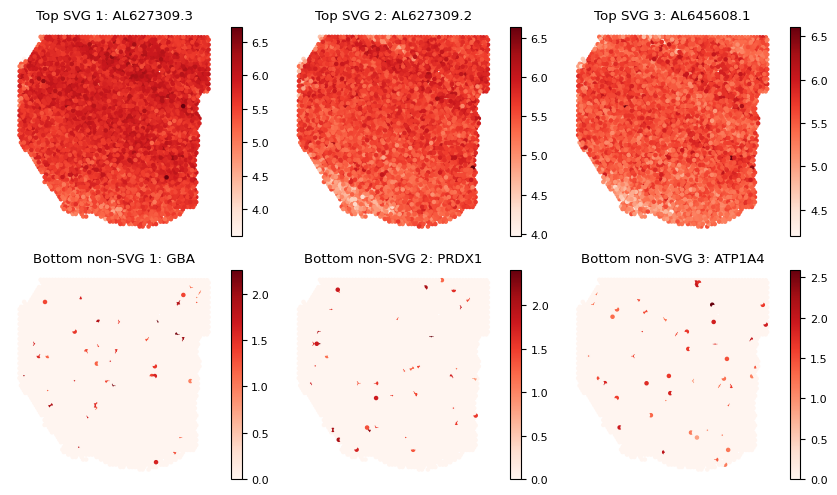

In [9]:
gene_ranking = svg_results['gene_ranking']
# Create a single figure with subplots for top SVGs and bottom non-SVGs  
plt.figure(figsize=(8.5, 5), dpi=100)  
plt.rcParams['font.size'] = 8  
# Plot top 3 SVGs  
for i in range(3):  
    plt.subplot(2, 3, i+1)  
    gene_idx = gene_ranking[i]  
    gene_name = adata.var_names[gene_idx]  
    gene_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    
    scatter = plt.scatter(separ.adata.obsm['spatial'][:, 0],   
                        -separ.adata.obsm['spatial'][:, 1],  
                        c=gene_exp, s=5, cmap='Reds')  
    plt.title(f'Top SVG {i+1}: {gene_name}')  
    plt.axis('off')  
    plt.colorbar(scatter)  

# Plot bottom 3 non-SVGs  
for i in range(3):  
    plt.subplot(2, 3, i+4)  
    gene_idx = gene_ranking[-(i+1)]  
    gene_name = adata.var_names[gene_idx]  
    gene_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    
    scatter = plt.scatter(separ.adata.obsm['spatial'][:, 0],   
                        -separ.adata.obsm['spatial'][:, 1],  
                        c=gene_exp, s=5, cmap='Reds')  
    plt.title(f'Bottom non-SVG {i+1}: {gene_name}')  
    plt.axis('off')  
    plt.colorbar(scatter)  

plt.tight_layout()  
plt.show()

## 4. Gene Expression Refinement

In [10]:
adata_refined = separ.get_refined_expression()

#### Returns:  
- `adata_refined`: AnnData object  
  - Contains denoised gene expression matrix 
  - Preserves original gene names and spot indices from input AnnData  
  - `.X`: Stores the refined expression matrix  

### Evaluating Refinement Performance  
 
First, we use Moran's I statistic to quantitatively evaluate the improvement in spatial patterns. Moran's I measures spatial autocorrelation, with higher values indicating stronger spatial patterns. The violin plot below compares the distribution of Moran's I values between raw and refined expression data across all genes: 

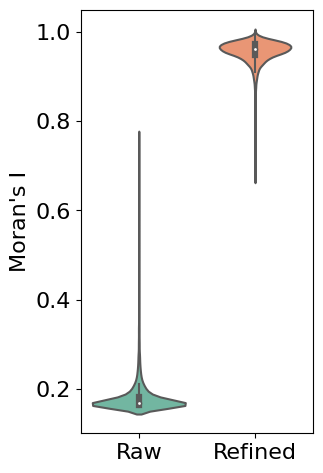

In [11]:
# Calculate Moran's I for both raw and refined data  
morani = sc.metrics.morans_i(separ.adata)  
morani_refine = sc.metrics.morans_i(adata_refined)  

# Create DataFrame for violin plot  
data_violin = pd.DataFrame({  
    'Moran\'s I': np.concatenate([morani, morani_refine]),  
    'Condition': ['Raw'] * len(morani) + ['Refined'] * len(morani_refine)  
})  

import seaborn as sns
# Create violin plot  
plt.rcParams['font.size'] = 16  
plt.figure(figsize=(3, 5.5))  
sns.violinplot(x='Condition', y='Moran\'s I', data=data_violin, palette='Set2')  
plt.ylabel('Moran\'s I')  
plt.xlabel('')  
plt.show()  

### Single Gene Visualization

To demonstrate the refinement effect at individual gene level, we visualize the spatial expression pattern of a single gene. The comparison shows how SEPAR preserves and enhances genuine spatial patterns while reducing technical noise:

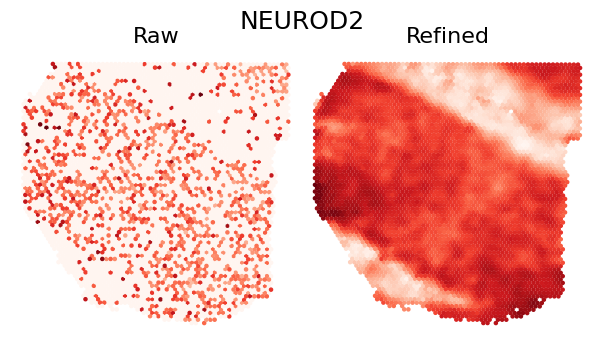

In [12]:
def plot_gene_refinement(gene_name, separ, adata_refined):  
    """  
    Visualize raw and refined expression patterns for a specific gene.  
    
    Parameters  
    ----------  
    gene_name : str  
        Name of the gene to visualize  
    separ : SEPAR object  
        SEPAR object containing raw data  
    adata_refined : AnnData  
        Refined expression data from get_refined_expression()  
    """  
    # Get gene index and expression values  
    gene_idx = separ.adata.var_names.get_loc(gene_name)  
    raw_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    refined_exp = adata_refined.X[:, gene_idx]  

    # Create comparison plot  
    plt.rcParams['font.size'] = 16  
    plt.figure(dpi=100, figsize=(7/1.2, 4/1.2))  
    
    # Set main title  
    plt.suptitle(gene_name, fontsize=18)  
    
    # Plot raw expression  
    plt.subplot(1, 2, 1)  
    plt.scatter(separ.loc[:, 0], -separ.loc[:, 1],  
                c=raw_exp, s=5, cmap='Reds', rasterized=True)  
    plt.axis('off')  
    plt.title('Raw', fontsize=16)  
    
    # Plot refined expression  
    plt.subplot(1, 2, 2)  
    plt.scatter(separ.loc[:, 0], -separ.loc[:, 1],  
                c=refined_exp, s=5, cmap='Reds', rasterized=True)  
    plt.axis('off')  
    plt.title('Refined', fontsize=16)  
    
    plt.tight_layout(pad=0)  
    plt.show()  

plot_gene_refinement("NEUROD2", separ, adata_refined)

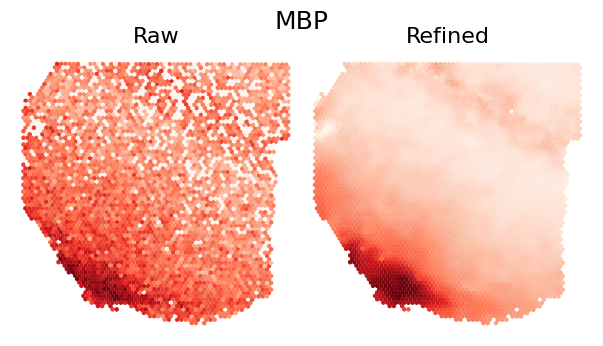

In [13]:
plot_gene_refinement("MBP", separ, adata_refined)  

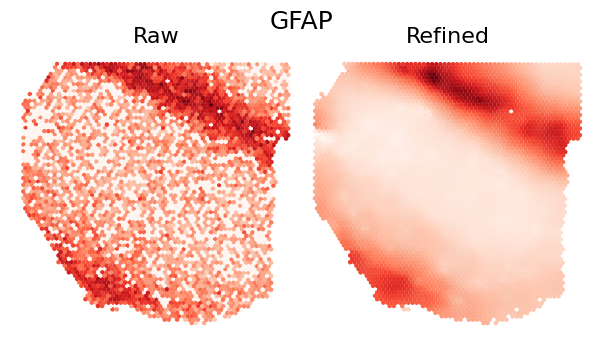

In [14]:
plot_gene_refinement("GFAP", separ, adata_refined)

## 5. Performing Clustering

In [17]:
# Perform clustering
cluster_res = separ.clustering(n_cluster=n_cluster, N1=30-n_cluster-7, N2=5)

### Parameters Explanation:
- `n_cluster`: Integer
  - Number of spatial domains to identify

- `N1`: Integer, optional
  - Number of patterns to retain after l2-norm filtering
  - Default: r - 5 - n_cluster (where r is the total number of patterns)

- `N2`: Integer, default=3
  - Number of patterns to retain after Pattern Specificity Score (PSS) filtering
  - Default value is 3 as specified in the paper

### Results Storage:
- `self.labelres`: Array of cluster labels for each spot
- `self.adata.obs['clustering']`: Cluster assignments stored in AnnData object

### Clustering Results Visualization

Compare the manual annotation with SEPAR clustering results:

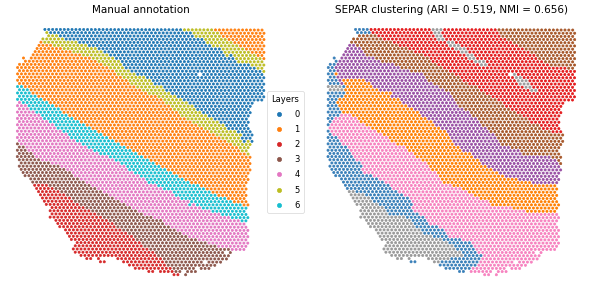

In [18]:
# Calculate clustering metrics
Y_list = separ.adata.obs['Region']
Ari = adjusted_rand_score(Y_list, separ.labelres)
Nmi = nmi(Y_list, separ.labelres)

# Create visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi = 50)
plt.rcParams['font.size'] = 12  
# Manual annotation plot
groups = separ.adata.obs['Region'].astype('str')
unique_regions = groups.unique()
region_to_num = {region: num for num, region in enumerate(unique_regions)}
groups = separ.adata.obs['Region'].map(region_to_num)

scatter = axs[0].scatter(separ.loc[:, 0], -separ.loc[:, 1], 
                        c=groups, s=10, cmap='tab10')
axs[0].set_title("Manual annotation", fontsize=15)
axs[0].axis('off')
legend = axs[0].legend(*scatter.legend_elements(), 
                      title="Layers",
                      bbox_to_anchor=(0.95, 0.5),
                      loc='center left')

# SEPAR clustering plot
scatter = axs[1].scatter(separ.loc[:, 0], -separ.loc[:, 1], 
                        c=separ.labelres, s=10, cmap='Set1')
axs[1].set_title(f"SEPAR clustering (ARI = {Ari:.3f}, NMI = {Nmi:.3f})", 
                 fontsize=15)
axs[1].axis('off')

plt.tight_layout()
plt.show()